In [1]:
import sys
sys.path.insert(0,'../..')

In [2]:
from numerical_integrators.singlestep import rk4
from numerical_integrators.adaptive_step import rkdp87

In [3]:
import multiprocessing as mp
import numpy as np

In [4]:
import matplotlib as mpl
mpl.use("pgf")

# Custom matplotlib config (fonts etc)

## TeX preamble
pgf_with_pdflatex = {
    "font.family": "serif",
    "text.usetex": True,
    "text.latex.unicode": True,
    "pgf.texsystem": "pdflatex",
    "pgf.preamble": [
         r"\usepackage[utf8x]{inputenc}",
         r"\usepackage[T1]{fontenc}",
         r"\usepackage[]{libertine}"
         r"\usepackage[libertine]{newtxmath}"
         ]
}
mpl.rcParams.update(pgf_with_pdflatex)

mpl.rcParams['font.family'] = 'Libertine'

from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Linux Libertine']})

import matplotlib.font_manager as fm
prop = fm.FontProperties(fname='/usr/local/texlive/2017/texmf-dist/fonts/opentype/public/libertine/LinLibertine_DR.otf')

from matplotlib import pyplot as plt
plt.rc('text',usetex=True)
plt.rc('figure',figsize=(5.05,3.1),dpi=100)
plt.rc('text.latex',preamble=[r'\usepackage[]{libertine}',r'\usepackage[libertine]{newtxmath}'])
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

In [5]:
def f(t,x,A=1,B=1,C=1):
    """
    param: t -- Time
    param: x -- Twelve-component (NumPy) array, containing the flow map and Jacobian at time t. 
                Shape: (12,nx,ny,nz)
    
    return: Twelve-component array, containing the (component-wise) right hand side of the
            coupled equation of variations
            Shape: (12,nx,ny,nz)
    """
    ret = np.empty(x.shape)
    ret[0]  = A*np.sin(x[2]) + C*np.cos(x[1])                # x-component of velocity field
    ret[1]  = B*np.sin(x[0]) + A*np.cos(x[2])                # y-component of velocity field
    ret[2]  = C*np.sin(x[1]) + B*np.cos(x[0])                # z-component of velocity field
    ret[3]  = -C*np.sin(x[1])*x[6] + A*np.cos(x[2])*x[9]     # The remaining (coupled) entries 
    ret[4]  = -C*np.sin(x[1])*x[7] + A*np.cos(x[2])*x[10]    # constitute the RHS of the 
    ret[5]  = -C*np.sin(x[1])*x[8] + A*np.cos(x[2])*x[11]    # variational ODE for the 
    ret[6]  = B*np.cos(x[0])*x[3] + -A*np.sin(x[2])*x[9]     # flow map Jacobian
    ret[7]  = B*np.cos(x[0])*x[4] + -A*np.sin(x[2])*x[10]
    ret[8]  = B*np.cos(x[0])*x[5] + -A*np.sin(x[2])*x[11]
    ret[9]  = -B*np.sin(x[0])*x[3] + C*np.cos(x[1])*x[6]
    ret[10] = -B*np.sin(x[0])*x[4] + C*np.cos(x[1])*x[7]
    ret[11] = -B*np.sin(x[0])*x[5] + C*np.cos(x[1])*x[8]
    return ret

def compute_strain_eigenvalues_and_vectors(t0,x,y,z,tf,h,func,integ,nproc=4):
    jac = find_endpoint_jacobian(t0,x,y,z,tf,h,func,integ,nproc)
    u,s,v = np.linalg.svd(jac)
    
    lm1 = s[...,2]**2
    lm2 = s[...,1]**2
    lm3 = s[...,0]**2
    
    xi1 = v[...,2]
    xi2 = v[...,1]
    xi3 = v[...,0]
    
    return (lm1, lm2, lm3), (xi1, xi2, xi3)
    
def find_endpoint_jacobian(t0,x,y,z,tf,h,func,integ,nproc):
    grid = np.zeros((12,x.shape[0],y.shape[0],z.shape[0]))
    grid[:3] = np.array(np.meshgrid(x,y,z,indexing='ij'))    # Initial conditions (to be advected)
    grid[3]  = 1                                             # Initial condition for the flow map Jacobian: 
    grid[7]  = 1                                             #     Identity matrices
    grid[11] = 1
    
    # Divide the advection across the no. of available processor cores
    div = np.ceil(np.linspace(0,x.shape[0],nproc+1)).astype(int) 
    
    # Initialize queues and processes for multiprocessing
    qs = [mp.Queue() for j in range(nproc)]
    ps = [mp.Process(target=_advect_slice,
                     args=(t0,grid[:,div[j]:div[j+1]],tf,h,func,integ,qs[j]))
          for j in range(nproc)]
    
    # Initiate subprocesses
    [p.start() for p in ps]
    # Gather results
    for j, q in enumerate(qs):
        grid[:,div[j]:div[j+1]] = q.get()
    # Enforce termination of each process
    [p.join() for p in ps]
    
    # Return only the Jacobian, reshaped for later convenience
    return grid[3:].transpose(1,2,3,0).reshape((x.shape[0],y.shape[0],z.shape[0],3,3))

def _advect_slice(t0,pos,tf,h,func,integ,q):
    if integ == rk4:
        t = t0
        for j in range(np.ceil((tf-t0)/h).astype(int)):
            t,pos,h = integ(t,pos,h,func)
        q.put(pos)
    elif integ == rkdp87:
        t = np.ones(pos.shape[1:])*t0
        h = np.ones(pos.shape[1:])*h
        while np.any(t<tf):
            h = np.minimum(h,tf-t)
            t,pos,h = integ(t,pos,h,func)
        q.put(pos)
    else:
        raise RuntimeError('Integrator configuration not loaded!')

In [6]:
# Advection parameters
t0 = 0
tf = 1
h = 0.1
flowmap_integrator = rkdp87

# Grid parameters
xmin = 0
xmax = 2*np.pi
ymin = 0
ymax = 2*np.pi
zmin = 0
zmax = 2*np.pi

nx = 101
ny = 102
nz = 103

x,dx = np.linspace(xmin,xmax,nx,retstep=True)
y,dy = np.linspace(ymin,ymax,ny,retstep=True)
z,dz = np.linspace(zmin,zmax,nz,retstep=True)

In [7]:
# Compute eigenvalues and -vectors of the Cauchy-Green strain tensor:

(lm1,lm2,lm3),(xi1,xi2,xi3) = compute_strain_eigenvalues_and_vectors(t0,x,y,z,tf,h,f,flowmap_integrator)

In [8]:
# Compute Hessian efficiently by making use of NumPy's gradient function
def compute_hessian_lm(lm,dx,dy,dz):
    grad = np.gradient(lm,dx,dy,dz,edge_order=2)
    hessian = np.empty((x.shape[0],y.shape[0],z.shape[0],3,3))
    for k, grad_k in enumerate(grad):
        # Iterate over the number of dimensions
        # Apply gradient operator to each component of the first derivative
        tmp_grad = np.gradient(grad_k,dx,dy,dz,edge_order=2)
        for l, grad_kl in enumerate(tmp_grad):
            hessian[...,k,l] = grad_kl
    return hessian

In [9]:
def find_points_in_AB(hess_lm3,lm3,lm2,xi3):
    mask_a = np.logical_and(np.greater(lm3,1),np.greater(lm3,lm2))
    mask_b = np.less_equal(np.sum(xi3*np.sum(hess_lm3*xi3[...,np.newaxis],axis=3),axis=3),0)
    return np.logical_and(mask_a,mask_b)

In [10]:
hlm3 = compute_hessian_lm(lm3,x,y,z)

In [11]:
mask_ab = find_points_in_AB(hlm3,lm3,lm2,xi3)

In [168]:
# Porting a point version of the Dormand-Prince 5(4) integrator

def dp54_p(t,x,h,f,atol=1e-6,rtol=1e-9,**kwargs):
    
    # Safety factors for the update of the timestep
    fac = 0.8
    maxfac = 2.
    
    # Nodes
    c2 = 1./5.
    c3 = 3./10.
    c4 = 4./5.
    c5 = 8./9.
    c6 = 1.
    c7 = 1.
    
    # Matrix elements
    a21 = 1./5.
    a31 = 3./40.
    a32 = 9./40.
    a41 = 44./45.
    a42 = -56./15.
    a43 = 32./9.
    a51 = 19372./6561.
    a52 = -25360./2187.
    a53 = 6448./6561.
    a54 = -212./729.
    a61 = 9017./3168.                                                           
    a62 = -355./33.                                                             
    a63 = 46732./5247.                                                          
    a64 = 49./176.                                                              
    a65 = -5103./18656.                                                         
    a71 = 35./384.                                                              
    a72 = 0.                                                                    
    a73 = 500./1113.                                                            
    a74 = 125./192.                                                             
    a75 = -2187./6784.                                                          
    a76 = 11./84.     
    
    # Fourth-order weights                                                      
    b41 = 5179./57600.                                                          
    b42 = 0.                                                                    
    b43 = 7571./16695.                                                          
    b44 = 393./640.                                                             
    b45 = -92097./339200.                                                       
    b46 = 187./2100.                                                            
    b47 = 1./40.                                                                
                                                                                
    # Fifth-order weights                                                       
    b51 = 35./384.                                                              
    b52 = 0.                                                                    
    b53 = 500./1113.                                                            
    b54 = 125./192.                                                             
    b55 = -2187./6784.                                                          
    b56 = 11./84.                                                               
    b57 = 0.      
    
    # Fourth-order weights                                                      
    b41 = 5179./57600.                                                          
    b42 = 0.                                                                    
    b43 = 7571./16695.                                                          
    b44 = 393./640.                                                             
    b45 = -92097./339200.                                                       
    b46 = 187./2100.                                                            
    b47 = 1./40.                                                                
                                                                                
    # Fifth-order weights                                                       
    b51 = 35./384.                                                              
    b52 = 0.                                                                    
    b53 = 500./1113.                                                            
    b54 = 125./192.                                                             
    b55 = -2187./6784.                                                          
    b56 = 11./84.                                                               
    b57 = 0.                                                                    
                                                                                
    # Find "slopes"                                                             
    k1 = f(t       , x                                               , **kwargs)
    k2 = f(t + c2*h, x + a21*h*k1                                    , **kwargs)
    k3 = f(t + c3*h, x + a31*h*k1 + a32*h*k2                         , **kwargs)
    k4 = f(t + c4*h, x + a41*h*k1 + a42*h*k2 + a43*h*k3              , **kwargs)
    k5 = f(t + c5*h, x + a51*h*k1 + a52*h*k2 + a53*h*k3 + a54*h*k4   , **kwargs)
    k6 = f(t + c6*h, x + a61*h*k1 + a62*h*k2 + a63*h*k3 + a64*h*k4              
                                                + a65*h*k5           , **kwargs)
    k7 = f(t + c7*h, x + a71*h*k1 + a72*h*k2 + a73*h*k3 + a74*h*k4              
                                                + a75*h*k5 + a76*h*k6, **kwargs)
    
    # Find fourth and fifth order prediction of new point                       
    x_4 = x + h*(b41*k1 + b42*k2 + b43*k3 + b44*k4 + b45*k5 + b46*k6 + b47*k7)  
    x_5 = x + h*(b51*k1 + b52*k2 + b53*k3 + b54*k4 + b55*k5 + b56*k6 + b57*k7)  
                                                                                
    # Implementing error check and variable stepsize roughly as in              
    # Hairer, Nørsett and Wanner: "Solving ordinary differential                
    #                              equations I -- Nonstiff problems",           
    #                              pages 167 and 168 in the 2008 ed.            
                                                                                
    # The method is 5th order, with 4th order interpolation, hence:             
    q = 4.                                                                      
                                                                                
    sc = atol + np.maximum(np.abs(x_4), np.abs(x_5)) * rtol                     
    err = np.sqrt((x_4-x_5)**2)/sc 
    
    # Should the error happen to be zero, the optimal timestep is infinity.     
    # We set an upper limit in order to ensure sensible behaviour.              
    # In addition, we make sure we step in the direction originally intended;   
    # when integrating backwards in time, we need negative timesteps, hence: 
    
    if err == 0:
        h_opt = np.sign(h)*10
    else:
        h_opt = h*(1/err)**(1/(q+1.))
    
    # Step accepted if err < 1, meaning t, x and h are updated
    if err < 1:
        _t = t + h
        _x = x_5
        _h = np.maximum(maxfac*h, fac*h_opt)
    # Step rejected if err > 1, meaning only h is updated
    else:
        _t = t
        _x = x
        _h = fac*h_opt
    
    return _t, _x, _h

In [189]:
g0 = np.array(np.meshgrid(x,y,z,indexing='ij')).transpose(1,2,3,0)[mask_ab]

In [190]:
g0.shape

(502235, 3)

In [184]:
np.sum(hlm3*xi3[...,np.newaxis],axis=3).shape

(101, 102, 103, 3)

In [183]:
xi3.shape

(101, 102, 103, 3)

In [127]:
g[1,0,0]

array([0.06346652, 0.        , 0.        ])

In [128]:
dx

0.06346651825433926

In [147]:
X,Y = np.meshgrid(x,y,indexing='ij')

In [153]:
foo = X**2+Y**2
dfoo = np.array(np.gradient(foo,x,y,edge_order=2))

<IPython.core.display.Javascript object>


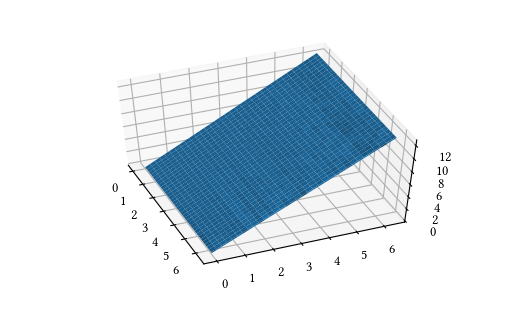

In [158]:
fig=plt.figure()
ax=fig.add_subplot(111,projection='3d')
ax.plot_surface(X,Y,dfoo[1])

In [144]:
dfoo

array([ 0.        ,  0.12566371,  0.25132741,  0.37699112,  0.50265482,
        0.62831853,  0.75398224,  0.87964594,  1.00530965,  1.13097336,
        1.25663706,  1.38230077,  1.50796447,  1.63362818,  1.75929189,
        1.88495559,  2.0106193 ,  2.136283  ,  2.26194671,  2.38761042,
        2.51327412,  2.63893783,  2.76460154,  2.89026524,  3.01592895,
        3.14159265,  3.26725636,  3.39292007,  3.51858377,  3.64424748,
        3.76991118,  3.89557489,  4.0212386 ,  4.1469023 ,  4.27256601,
        4.39822972,  4.52389342,  4.64955713,  4.77522083,  4.90088454,
        5.02654825,  5.15221195,  5.27787566,  5.40353936,  5.52920307,
        5.65486678,  5.78053048,  5.90619419,  6.03185789,  6.1575216 ,
        6.28318531,  6.40884901,  6.53451272,  6.66017643,  6.78584013,
        6.91150384,  7.03716754,  7.16283125,  7.28849496,  7.41415866,
        7.53982237,  7.66548607,  7.79114978,  7.91681349,  8.04247719,
        8.1681409 ,  8.29380461,  8.41946831,  8.54513202,  8.67

In [145]:
foo

array([0.00000000e+00, 3.94784176e-03, 1.57913670e-02, 3.55305758e-02,
       6.31654682e-02, 9.86960440e-02, 1.42122303e-01, 1.93444246e-01,
       2.52661873e-01, 3.19775183e-01, 3.94784176e-01, 4.77688853e-01,
       5.68489214e-01, 6.67185258e-01, 7.73776985e-01, 8.88264396e-01,
       1.01064749e+00, 1.14092627e+00, 1.27910073e+00, 1.42517088e+00,
       1.57913670e+00, 1.74099822e+00, 1.91075541e+00, 2.08840829e+00,
       2.27395685e+00, 2.46740110e+00, 2.66874103e+00, 2.87797664e+00,
       3.09510794e+00, 3.32013492e+00, 3.55305758e+00, 3.79387593e+00,
       4.04258996e+00, 4.29919968e+00, 4.56370508e+00, 4.83610616e+00,
       5.11640292e+00, 5.40459537e+00, 5.70068350e+00, 6.00466732e+00,
       6.31654682e+00, 6.63632200e+00, 6.96399287e+00, 7.29955942e+00,
       7.64302165e+00, 7.99437956e+00, 8.35363317e+00, 8.72078245e+00,
       9.09582742e+00, 9.47876807e+00, 9.86960440e+00, 1.02683364e+01,
       1.06749641e+01, 1.10894875e+01, 1.15119066e+01, 1.19422213e+01,
      

In [146]:
2*2*np.pi

12.566370614359172